# Collabrate Filtering

## Import Library

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_excel('../dataset/Online Retail.xlsx', sheet_name='Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df = df.dropna(subset=['CustomerID'])

In [5]:
df.shape

(406829, 8)

In [6]:
df["StockCode"].nunique()

3684

In [7]:
df["CustomerID"].nunique()

4372

In [8]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [9]:
df["InvoiceDate"].describe()

/tmp/ipykernel_4058423/888986878.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["InvoiceDate"].describe()


count                  406829
unique                  20460
top       2011-11-14 15:27:00
freq                      543
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [14]:
customer_item_matrix = df.pivot_table(
    index='CustomerID', 
    columns='StockCode', 
    values='Quantity',
    aggfunc='sum'
)

In [15]:
customer_item_matrix.shape

(4372, 3684)

In [19]:
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)
customer_item_matrix.head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 1. Market Basket Analysis

In [21]:
#%pip install mlxtend

In [22]:
from mlxtend.frequent_patterns import apriori, association_rules

at_least_100_sold_items = customer_item_matrix.columns[(customer_item_matrix.sum() > 100)]
at_least_100_sold_items

Index([   15036,    16237,    17003,    20668,    20674,    20675,    20676,
          20677,    20679,    20682,
       ...
       '85049C', '85049E', '85049G', '85099B', '85099C', '85099F', '85123A',
       '85184C',      'M',   'POST'],
      dtype='object', name='StockCode', length=904)

In [23]:
at_least_20_purchase_customers = customer_item_matrix.loc[
    (customer_item_matrix[at_least_100_sold_items].sum(axis=1) >= 20)].index
at_least_20_purchase_customers

Float64Index([12347.0, 12349.0, 12352.0, 12354.0, 12356.0, 12357.0, 12359.0,
              12360.0, 12362.0, 12364.0,
              ...
              18248.0, 18252.0, 18257.0, 18259.0, 18260.0, 18263.0, 18265.0,
              18272.0, 18283.0, 18287.0],
             dtype='float64', name='CustomerID', length=2519)

In [24]:
mb_matrix = customer_item_matrix.loc[at_least_20_purchase_customers][at_least_100_sold_items]
mb_matrix.shape

(2519, 904)

### 1.1. Apriori - Frequent Item Sets

In [26]:
frequent_items = apriori(
    customer_item_matrix, 
    min_support=0.03,
    use_colnames=True
)

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [27]:
frequent_items["n_items"] = frequent_items["itemsets"].apply(lambda x: len(x))
frequent_items

,support,itemsets,n_items
0,0.044145,(15036),1
1,0.031107,(17003),1
2,0.034081,(20675),1
3,0.042315,(20676),1
4,0.030421,(20677),1
...,...,...,...
1951,0.034309,"(22383, 22384, 20725, 20727, 20728)",5
1952,0.032022,"(22382, 22383, 22384, 20725, 20727)",5
1953,0.033166,"(22382, 22383, 22384, 20725, 20728)",5
1954,0.030192,"(23207, 22382, 22383, 20725, 20728)",5


In [28]:
frequent_items["support"].describe()

count    1956.000000
mean        0.042293
std         0.016682
min         0.030192
25%         0.032479
50%         0.036597
75%         0.045059
max         0.198994
Name: support, dtype: float64

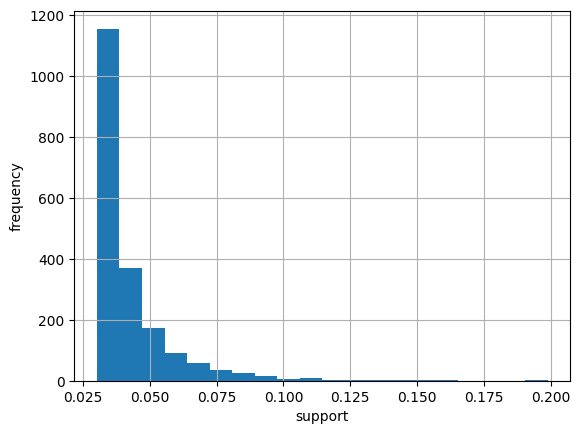

In [29]:
ax = frequent_items["support"].hist(bins=20)
ax.set_xlabel("support")
ax.set_ylabel("frequency")
plt.show()

### 1.2. Association Rules

In [32]:
rules = association_rules(
    frequent_items, 
    metric="confidence",
    min_threshold=0.6, 
    support_only=False
)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(20712),(85099B),0.056267,0.144556,0.038655,0.686992,4.752418,1.0,0.030521,2.732976,0.836657,0.238364,0.634099,0.477198
1,(20713),(85099B),0.047118,0.144556,0.034309,0.728155,5.037176,1.0,0.027498,3.146811,0.841107,0.218023,0.682218,0.482749
2,(20719),(20724),0.054209,0.076624,0.037283,0.687764,8.975830,1.0,0.033129,2.957299,0.939520,0.398533,0.661854,0.587165
3,(20723),(20724),0.052150,0.076624,0.037740,0.723684,9.444619,1.0,0.033744,3.341742,0.943313,0.414573,0.700755,0.608111
4,(20723),(22355),0.052150,0.056496,0.031336,0.600877,10.635770,1.0,0.028390,2.363944,0.955824,0.405325,0.576978,0.577767


In [33]:
most_lift = rules.sort_values(by="lift", ascending=False).head(20).pivot_table(
    index='antecedents', 
    columns='consequents', 
    values='lift',
    aggfunc='sum'
)

most_lift.index = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_lift.index
]

most_lift.columns = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_lift.columns
]

In [34]:
most_lift

,REGENCY TEA PLATE GREEN + ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER + REGENCY TEA PLATE ROSES,REGENCY TEA PLATE ROSES + REGENCY TEA PLATE GREEN,REGENCY TEA PLATE PINK,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES,REGENCY TEA PLATE GREEN,GREEN REGENCY TEACUP AND SAUCER + REGENCY TEA PLATE GREEN,GREEN REGENCY TEACUP AND SAUCER + REGENCY TEA PLATE PINK,REGENCY TEA PLATE ROSES + REGENCY TEA PLATE PINK,REGENCY TEA PLATE ROSES + ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER + REGENCY TEA PLATE ROSES + ROSES REGENCY TEACUP AND SAUCER
GREEN REGENCY TEACUP AND SAUCER + REGENCY TEA PLATE ROSES,26.010726,NaN,NaN,NaN,NaN,NaN,20.839579,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE GREEN + ROSES REGENCY TEACUP AND SAUCER,NaN,26.010726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE PINK,NaN,NaN,22.386747,NaN,NaN,NaN,20.879103,21.993293,NaN,NaN,NaN,NaN
REGENCY TEA PLATE ROSES + REGENCY TEA PLATE GREEN,NaN,NaN,NaN,22.386747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SET/6 RED SPOTTY PAPER PLATES,NaN,NaN,NaN,NaN,22.230756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SET/6 RED SPOTTY PAPER CUPS,NaN,NaN,NaN,NaN,NaN,22.230756,NaN,NaN,NaN,NaN,NaN,NaN
GREEN REGENCY TEACUP AND SAUCER + REGENCY TEA PLATE GREEN,NaN,NaN,NaN,21.993293,NaN,NaN,NaN,NaN,NaN,NaN,20.462228,NaN
GREEN REGENCY TEACUP AND SAUCER + REGENCY TEA PLATE PINK,NaN,NaN,NaN,NaN,NaN,NaN,21.761086,NaN,NaN,NaN,NaN,NaN
REGENCY TEA PLATE GREEN,NaN,20.839579,NaN,20.879103,NaN,NaN,NaN,NaN,21.761086,21.473167,NaN,20.945479
REGENCY TEA PLATE ROSES + REGENCY TEA PLATE PINK,NaN,NaN,NaN,NaN,NaN,NaN,21.473167,NaN,NaN,NaN,NaN,NaN


In [35]:
most_conf = rules.sort_values(by="confidence", ascending=False).head(20).pivot_table(
    index='antecedents', 
    columns='consequents', 
    values='confidence',
    aggfunc='sum'
)

most_conf.index = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_conf.index
]

most_conf.columns = [
    " + ".join([df.loc[df["StockCode"] == item]["Description"].unique()[0] for item in list(x)]) for x in most_conf.columns
]

### 1.3 Visualization

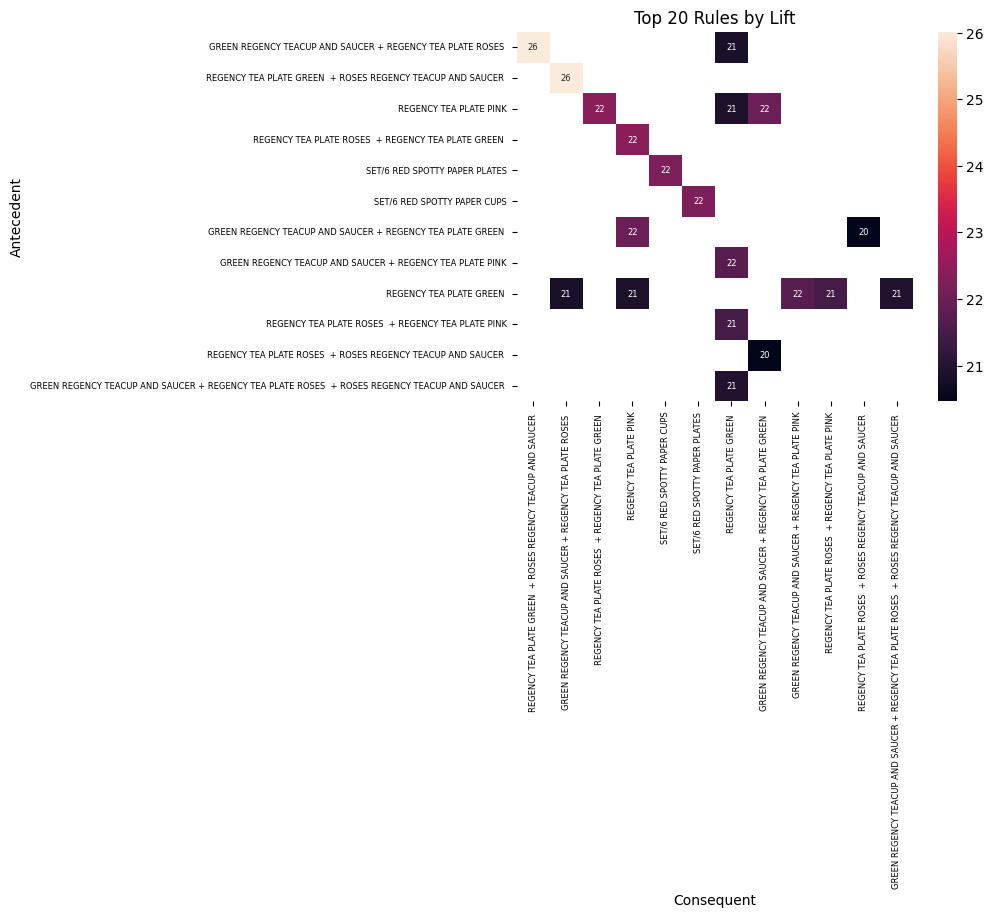

In [36]:
ax = plt.subplot()
sns.heatmap(
    most_lift, 
    annot=True, 
    annot_kws={"size": 6},
    # fmt=".1f", 
    ax=ax
)
ax.set_title("Top 20 Rules by Lift")
ax.set_xlabel("Consequent")
ax.set_ylabel("Antecedent")
ax.yaxis.set_ticklabels(list(most_lift.index), fontsize=6)
ax.xaxis.set_ticklabels(list(most_lift.columns), fontsize=6)
plt.show()

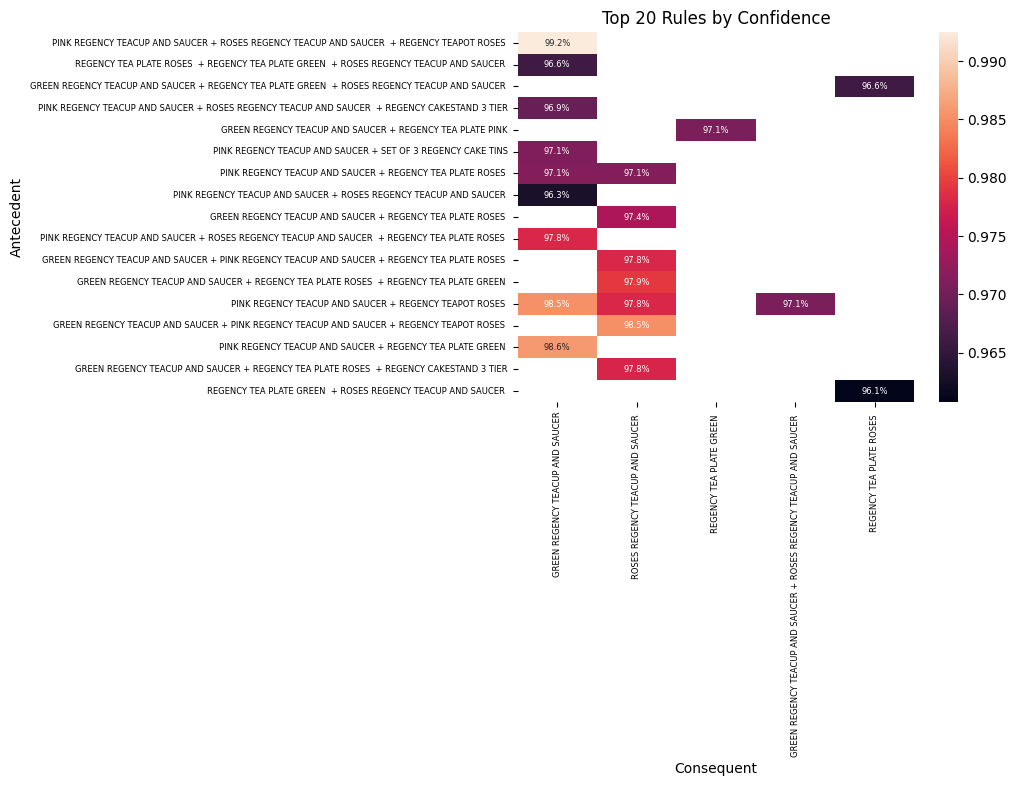

In [37]:
ax = plt.subplot()
sns.heatmap(
    most_conf, 
    annot=True, 
    annot_kws={"size": 6},
    fmt=".1%", 
    ax=ax
)
ax.set_title("Top 20 Rules by Confidence")
ax.set_xlabel("Consequent")
ax.set_ylabel("Antecedent")
ax.yaxis.set_ticklabels(list(most_conf.index), fontsize=6)
ax.xaxis.set_ticklabels(list(most_conf.columns), fontsize=6)
plt.show()

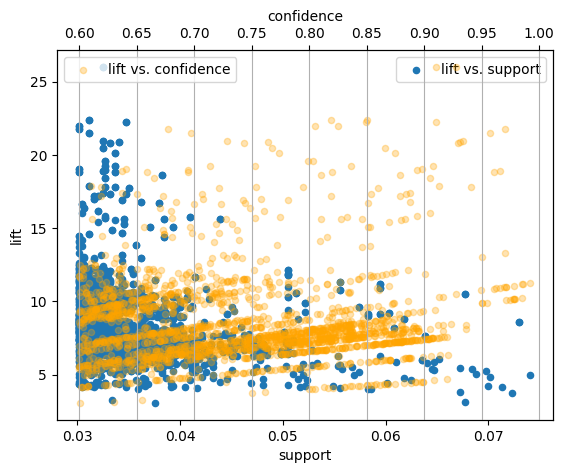

In [38]:
# linear with confidence & inverse with support as lift = confidence / support

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

rules[["support","lift"]].plot(
    kind="scatter", x="support", y="lift", ax=ax1
)
rules[["confidence","lift"]].plot(
    kind="scatter", x="confidence", y="lift", ax=ax2, color="orange", alpha=0.3
)

ax1.legend(["lift vs. support",], loc="upper right")
ax2.legend(["lift vs. confidence",], loc="upper left")
plt.grid()
plt.show()

## 2. User-Based Collaborative Filtering

### CF Training

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

user_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix)
)

In [45]:
user_user_sim_matrix.shape

(4372, 4372)

In [46]:
user_user_sim_matrix.columns = customer_item_matrix.index

user_user_sim_matrix['CustomerID'] = customer_item_matrix.index
user_user_sim_matrix = user_user_sim_matrix.set_index('CustomerID')

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [47]:
user_user_sim_matrix.loc[
    [12347.0, 12348.0, 12349.0, 12350.0, 12352.0],
    [12347.0, 12348.0, 12349.0, 12350.0, 12352.0]
]

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


CustomerID,12347.0,12348.0,12349.0,12350.0,12352.0
CustomerID,,,,,
12347.0,1.000000,0.063022,0.046130,0.047795,0.038814
12348.0,0.063022,1.000000,0.024953,0.051709,0.027995
12349.0,0.046130,0.024953,1.000000,0.056773,0.138314
12350.0,0.047795,0.051709,0.056773,1.000000,0.031846
12352.0,0.038814,0.027995,0.138314,0.031846,1.000000


### Making Recommendations

In [49]:
TARGET_CUSTOMER = 14806.0

In [50]:
print("Similar Customers to TARGET")
user_user_sim_matrix.loc[TARGET_CUSTOMER].sort_values(ascending=False).head(10)

Similar Customers to TARGET


CustomerID
14806.0    1.000000
13919.0    0.251478
12561.0    0.226134
13711.0    0.181818
12618.0    0.181818
13116.0    0.165145
12497.0    0.161165
17475.0    0.161165
12372.0    0.155126
14840.0    0.150756
Name: 14806.0, dtype: float64

In [51]:
items_bought_by_target = set(
    df.loc[
        df["CustomerID"] == TARGET_CUSTOMER
    ]["StockCode"].unique()
)
items_bought_by_target

{21499,
 21500,
 22704,
 22711,
 23079,
 23232,
 23550,
 '72351B',
 '84508C',
 84580,
 85175}

### Recommending by the most similar customer

In [52]:
items_bought_by_sim = set(
    df.loc[
        df["CustomerID"] == 13919.0
    ]["StockCode"].unique()
)
items_bought_by_sim

{'16161P',
 '16161U',
 '16169E',
 21498,
 21499,
 21500,
 21731,
 22046,
 22567,
 22666,
 22704,
 22707,
 22711,
 22847,
 22961,
 23233,
 23511,
 23512,
 23513,
 23515,
 23518,
 23546,
 23547,
 'POST'}

In [53]:
items_bought_by_sim_but_not_by_target = items_bought_by_sim - items_bought_by_target
df.loc[
    df["StockCode"].isin(items_bought_by_sim_but_not_by_target)
][["StockCode", "Description"]].drop_duplicates()

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,StockCode,Description
39,21731,RED TOADSTOOL LED NIGHT LIGHT
45,POST,POSTAGE
105,22961,JAM MAKING SET PRINTED
1217,21498,RED RETROSPOT WRAP
1296,22666,RECIPE BOX PANTRY YELLOW DESIGN
1299,22567,20 DOLLY PEGS RETROSPOT
2116,22847,BREAD BIN DINER STYLE IVORY
5016,16161P,WRAP ENGLISH ROSE
9525,16161U,WRAP SUKI AND FRIENDS
9780,22847,"BREAD BIN, DINER STYLE, IVORY"


### Recommending by Similar Sums

In [54]:
top10_similar_users = user_user_sim_matrix.loc[TARGET_CUSTOMER].sort_values(ascending=False).head(11).to_dict()
top10_similar_users

{14806.0: 1.0,
 13919.0: 0.2514778453847726,
 12561.0: 0.22613350843332272,
 13711.0: 0.18181818181818182,
 12618.0: 0.18181818181818182,
 13116.0: 0.1651445647689541,
 12497.0: 0.16116459280507606,
 17475.0: 0.16116459280507606,
 12372.0: 0.15512630699850574,
 14840.0: 0.15075567228888181,
 15160.0: 0.15075567228888181}

In [55]:
potential_rec_items = {}
for user, cos_sim in top10_similar_users.items():
    if user == TARGET_CUSTOMER:
        continue
        
    items_bought_by_sim = list(set(
        df.loc[
            df["CustomerID"] == user
        ]["StockCode"].unique()
    ))

    for each_item in items_bought_by_sim:
        if each_item not in potential_rec_items:
            potential_rec_items[each_item] = 0
        potential_rec_items[each_item] += cos_sim

potential_rec_items = [(key, val) for key, val in potential_rec_items.items()]
potential_rec_items = sorted(potential_rec_items, key=lambda x: x[1], reverse=True)

In [56]:
potential_rec_items[:10]

[(21499, 1.328721467833565),
 (21500, 1.328721467833565),
 (21498, 0.8039205113921255),
 ('POST', 0.7495869270065362),
 (22704, 0.632737660816601),
 ('16161U', 0.5677687451883544),
 (22138, 0.4981090816217636),
 (22711, 0.4066041523832783),
 (22631, 0.38125981543182846),
 (22326, 0.38125981543182846)]

In [57]:
top_10_items = [x[0] for x in potential_rec_items[:10]]
df.loc[
    df["StockCode"].isin(top_10_items)
][["StockCode", "Description"]].drop_duplicates().set_index(
    "StockCode"
).loc[top_10_items]

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,Description
StockCode,
21499,BLUE POLKADOT WRAP
21500,PINK POLKADOT WRAP
21498,RED RETROSPOT WRAP
POST,POSTAGE
22704,WRAP RED APPLES
16161U,WRAP SUKI AND FRIENDS
22138,BAKING SET 9 PIECE RETROSPOT
22711,WRAP CIRCUS PARADE
22631,CIRCUS PARADE LUNCH BOX


### Recommending by Most Bought by Similar Customers

In [58]:
top10_similar_users = user_user_sim_matrix.loc[TARGET_CUSTOMER].sort_values(ascending=False).head(11).to_dict()
top10_similar_users

{14806.0: 1.0,
 13919.0: 0.2514778453847726,
 12561.0: 0.22613350843332272,
 13711.0: 0.18181818181818182,
 12618.0: 0.18181818181818182,
 13116.0: 0.1651445647689541,
 12497.0: 0.16116459280507606,
 17475.0: 0.16116459280507606,
 12372.0: 0.15512630699850574,
 14840.0: 0.15075567228888181,
 15160.0: 0.15075567228888181}

In [59]:
potential_rec_items = {}
for user, cos_sim in top10_similar_users.items():
    if user == TARGET_CUSTOMER:
        continue
        
    items_bought_by_sim = list(set(
        df.loc[
            df["CustomerID"] == user
        ]["StockCode"].unique()
    ))

    for each_item in items_bought_by_sim:
        if each_item not in potential_rec_items:
            potential_rec_items[each_item] = 0
        potential_rec_items[each_item] += 1

potential_rec_items = [(key, val) for key, val in potential_rec_items.items()]
potential_rec_items = sorted(potential_rec_items, key=lambda x: x[1], reverse=True)

In [60]:
potential_rec_items[:10]

[(21499, 7),
 (21500, 7),
 ('POST', 4),
 (21498, 4),
 ('16161U', 3),
 (22704, 3),
 (22138, 3),
 (22711, 2),
 (22631, 2),
 (22326, 2)]

In [61]:
top_10_items = [x[0] for x in potential_rec_items[:10]]
df.loc[
    df["StockCode"].isin(top_10_items)
][["StockCode", "Description"]].drop_duplicates().set_index(
    "StockCode"
).loc[top_10_items]

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,Description
StockCode,
21499,BLUE POLKADOT WRAP
21500,PINK POLKADOT WRAP
POST,POSTAGE
21498,RED RETROSPOT WRAP
16161U,WRAP SUKI AND FRIENDS
22704,WRAP RED APPLES
22138,BAKING SET 9 PIECE RETROSPOT
22711,WRAP CIRCUS PARADE
22631,CIRCUS PARADE LUNCH BOX


## 3. Item-Based Collaborative Filtering

### CF Training

In [62]:
item_item_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.T))

In [63]:
item_item_sim_matrix.columns = customer_item_matrix.T.index

item_item_sim_matrix['StockCode'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('StockCode')

In [64]:
item_item_sim_matrix

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.000000,0.094868,0.090351,0.063246,0.098907,0.095346,0.047673,0.076139,0.091050,...,0.000000,0.0,0.000000,0.029361,0.0,0.0,0.0,0.059423,0.00,0.070057
10080,0.000000,1.000000,0.000000,0.032774,0.045883,0.047836,0.000000,0.000000,0.082855,0.049541,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.017244,0.00,0.000000
10120,0.094868,0.000000,1.000000,0.057143,0.060000,0.041703,0.060302,0.060302,0.096309,0.028793,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.075165,0.00,0.000000
10125,0.090351,0.032774,0.057143,1.000000,0.042857,0.044682,0.043073,0.000000,0.051594,0.030849,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.075165,0.00,0.071209
10133,0.063246,0.045883,0.060000,0.042857,1.000000,0.281494,0.045227,0.060302,0.072232,0.057585,...,0.000000,0.0,0.000000,0.037139,0.0,0.0,0.0,0.067648,0.05,0.016615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000
DOT,0.000000,0.000000,0.000000,0.000000,0.000000,0.104257,0.150756,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.00,0.000000
M,0.059423,0.017244,0.075165,0.075165,0.067648,0.054855,0.101983,0.067989,0.063341,0.075747,...,0.000000,0.0,0.071307,0.000000,0.0,0.0,0.0,1.000000,0.00,0.045793


### Making Recommendations

#### Recommending by Most Similar Items

In [76]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [77]:
df.loc[
    df['StockCode'] == 22138, 
    ['StockCode', 'Description']
].drop_duplicates()

,StockCode,Description
19108,22138,BAKING SET 9 PIECE RETROSPOT


In [79]:
most_similar_items = item_item_sim_matrix.loc[
    22138
].sort_values(ascending=False).head(10)
most_similar_items

StockCode
22138    1.000000
22617    0.588564
22139    0.401167
22621    0.280712
21212    0.275546
22720    0.256271
22367    0.248812
22619    0.247993
23298    0.245219
22554    0.242206
Name: 22138, dtype: float64

In [80]:
rec_items = [
    x for x in most_similar_items.index if x != "22138"
]

df.loc[
    df['StockCode'].isin(rec_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[rec_items]

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,Description
StockCode,
22138,BAKING SET 9 PIECE RETROSPOT
22617,BAKING SET SPACEBOY DESIGN
22139,RETROSPOT TEA SET CERAMIC 11 PC
22621,TRADITIONAL KNITTING NANCY
21212,PACK OF 72 RETROSPOT CAKE CASES
22720,SET OF 3 CAKE TINS PANTRY DESIGN
22367,CHILDRENS APRON SPACEBOY DESIGN
22619,SET OF 6 SOLDIER SKITTLES
23298,SPOTTY BUNTING


#### Recommending using Multiple Item Purchase History

In [82]:
df.loc[
    df['StockCode'].isin([23166, 22720, 23243]), 
    ['StockCode', 'Description']
].drop_duplicates()

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,StockCode,Description
28715,22720,SET OF 3 CAKE TINS PANTRY DESIGN
61619,23166,MEDIUM CERAMIC TOP STORAGE JAR
217655,23243,SET OF TEA COFFEE SUGAR TINS PANTRY


In [83]:
item_item_sim_matrix[[
    23166, 22720, 23243
]].mean(axis=1).sort_values(
    ascending=False
).head(10)

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


StockCode
23243    0.593115
22720    0.592794
23166    0.499390
22722    0.417434
23165    0.403306
22666    0.369518
23167    0.364973
23245    0.322518
22993    0.320600
22961    0.305328
dtype: float64

In [84]:
rec_items = [
    x for x in item_item_sim_matrix[[
        23166, 22720, 23243
    ]].mean(axis=1).sort_values(ascending=False).head(13).index 
    if x not in [23166, 22720, 23243]
]

df.loc[
    df['StockCode'].isin(rec_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[rec_items]

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more 

,Description
StockCode,
22722,SET OF 6 SPICE TINS PANTRY DESIGN
23165,LARGE CERAMIC TOP STORAGE JAR
22666,RECIPE BOX PANTRY YELLOW DESIGN
23167,SMALL CERAMIC TOP STORAGE JAR
23245,SET OF 3 REGENCY CAKE TINS
22993,SET OF 4 PANTRY JELLY MOULDS
22961,JAM MAKING SET PRINTED
22960,JAM MAKING SET WITH JARS
23198,PANTRY MAGNETIC SHOPPING LIST
